[konlpy.org](http://konlpy.org/en/v0.4.4/)

# 형태소 분석

In [2]:
from konlpy.tag import Komoran

In [3]:
tagger = Komoran()  # 형태소 분석기

In [4]:
tagger.pos('한국어로 텍스트를 분석해 봅시다.')  # 형태소 분석

[('한국어', 'NNP'),
 ('로', 'JKB'),
 ('텍스트', 'NNG'),
 ('를', 'JKO'),
 ('분석', 'NNG'),
 ('하', 'XSV'),
 ('아', 'EC'),
 ('보', 'VX'),
 ('ㅂ시다', 'EF'),
 ('.', 'SF')]

In [5]:
tagger.nouns('한국어로 텍스트를 분석해 봅시다.')  # 명사 추출

['한국어', '텍스트', '분석']

## 다음 뉴스 가져오기

In [6]:
from urllib.parse import quote_plus

import tqdm
import requests
import lxml.html

In [32]:
query = '딥러닝'
url = 'http://search.daum.net/search?w=news&cluster=n&sort=recency&DA=PGD&q={query}&p={page}'

In [33]:
articles = []
for page in tqdm.tqdm_notebook(range(1, 200)):
    search_url = url.format(query=query, page=page)
    res = requests.get(search_url)
    root = lxml.html.fromstring(res.text)
    for link in root.cssselect('a.f_nb'):  # "다음뉴스" 링크만 추출
        news = requests.get(link.attrib['href'])
        news_root = lxml.html.fromstring(news.text)
        try:
            article = news_root.cssselect('section')[0]  # 본문 추출
            text = article.text_content()
            articles.append(text)
        except IndexError:          # IndexError가 발생할 경우 무시
            pass

In [34]:
len(articles)

801

## Term-Document Matrix

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
def get_noun(text):
    nouns = tagger.nouns(text)
    return [n for n in nouns if len(n) > 1]  # 2글자 이상인 명사만 추출

In [37]:
cv = CountVectorizer(tokenizer=get_noun, max_features=1000) # 한글인 경우에는 tokenizer 필요.
tdm = cv.fit_transform(articles)

## 단어 빈도순

In [38]:
import numpy
import operator

In [39]:
words = cv.get_feature_names()

In [40]:
count_mat = tdm.sum(axis=0)  # 단어 노출수 합계
count = numpy.squeeze(numpy.asarray(count_mat))

In [41]:
word_count = list(zip(words, count))
word_count = sorted(word_count, key=operator.itemgetter(1), reverse=True)
word_count[:30]

[('기술', 3347),
 ('인공지능', 2133),
 ('서비스', 1934),
 ('갤럭시', 1468),
 ('개발', 1410),
 ('주행', 1342),
 ('제공', 1246),
 ('삼성전자', 1226),
 ('자율', 1173),
 ('딥러닝', 1160),
 ('네이버', 1141),
 ('빅스', 1123),
 ('기능', 1085),
 ('기자', 992),
 ('정보', 988),
 ('적용', 969),
 ('스마트폰', 920),
 ('기반', 902),
 ('사용자', 859),
 ('활용', 831),
 ('사용', 790),
 ('인식', 788),
 ('연구', 775),
 ('데이터', 763),
 ('기업', 751),
 ('분석', 733),
 ('제품', 733),
 ('고객', 719),
 ('시장', 707),
 ('출시', 687)]

## WordCloud

In [48]:
%matplotlib inline
from matplotlib import pyplot
from wordcloud import WordCloud

In [51]:
wc = WordCloud(font_path='C:\\Windows\\Fonts\\NanumBarunGothic.ttf', background_color='white', width=400, height=300)

In [52]:
cloud = wc.generate_from_frequencies(dict(word_count))

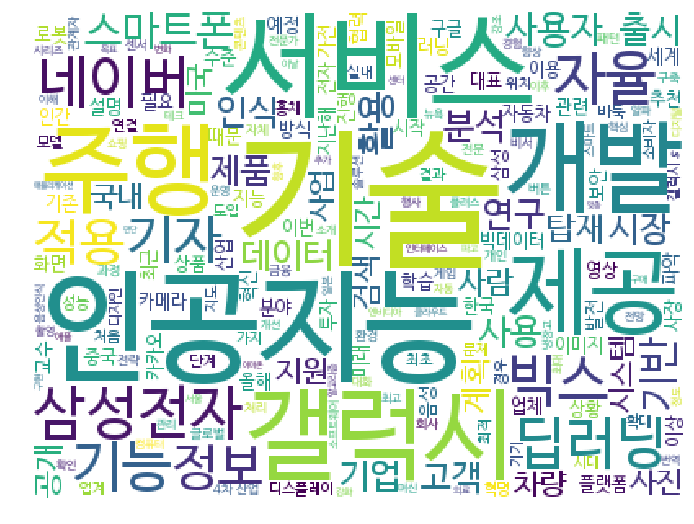

In [53]:
pyplot.figure(figsize=(12, 9))
pyplot.imshow(cloud)
pyplot.axis("off")
pyplot.show()

## Word Imbedding

같은 의미의 단어들을 하나의 단어로 간주해서 처리한다.

In [54]:
from sklearn.decomposition import TruncatedSVD

In [55]:
svd = TruncatedSVD()